In [130]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
from torchvision.utils import save_image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import glob
from PIL import Image
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
import torchvision.transforms.functional as TF
%matplotlib inline

In [194]:
class HealthyUnhealthyDataset(Dataset):
    
    
    dataset = None
    full_class_mapping = None
    healthy_images = None
    transform = None
    def __init__(self, data_dir = "PlantVillage-Dataset", plant_types = 'all', transform = None):
        self.data_dir = data_dir
        im_folders = glob.glob(data_dir + "/*/")
        self.im_folders = im_folders
        self.all_plants = list(set([a[:-1].split("/")[1].split("___")[0] for a in im_folders]))
        for plant in self.all_plants:
            if data_dir + "/" + plant + "___healthy/" not in im_folders:
                self.all_plants.remove(plant)
        if plant_types != 'all':
            self.all_plants = list(set(plant_types).intersection(set(self.all_plants)))
        print("plants in this dataset: {}".format(self.all_plants))
        self.get_paths_and_full_classes()
        
            
            
    def get_paths_and_full_classes(self):
        dataset = []
        full_class_mapping = {}
        full_class_idx = 0
        healthy_images = {plant:[] for plant in self.all_plants}
        for plant in self.all_plants:
            plant_folders = glob.glob(self.data_dir + "/" + plant + "*/")
            assert len(plant_folders) >= 2
            for plant_folder in plant_folders:
                images = glob.glob(plant_folder + "/*.JPG")
                #print(len(images))
                plant_name = plant_folder[:-1].split("/")[-1]
                if  plant_name not in full_class_mapping.keys():
                    full_class_mapping[plant_name]  = full_class_idx
                    full_class_idx += 1
                for image in images:
                    dataset.append({"path":image, 
                                    "full_class": plant_name,
                                    "healthy": 1 if "healthy" in plant_folder else 0
                                   })
                    if "healthy" in plant_folder:
                        healthy_images[plant_name.split("___")[0]].append(image)
        self.dataset = dataset
        self.full_class_mapping = full_class_mapping
        self.healthy_images = healthy_images
        self.to_tensor = torchvision.transforms.ToTensor
    
    
    
    
    IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

    @classmethod
    def pil_loader(cls, path: str) -> Image.Image:
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')


    # TODO: specify the return type
    @classmethod
    def accimage_loader(cls, path: str) -> Any:
        import accimage
        try:
            return accimage.Image(path)
        except IOError:
            # Potentially a decoding problem, fall back to PIL.Image
            return pil_loader(path)

    @classmethod
    def default_loader(cls, path: str) -> Any:
        from torchvision import get_image_backend
        if get_image_backend() == 'accimage':
            return cls.accimage_loader(path)
        else:
            return cls.pil_loader(path)
    
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        full_class = self.dataset[idx]['full_class']
        plant_name = full_class.split("___")[0]
        
        healthy_image_fn = self.healthy_images[plant_name][0]
        unknown_image_fn = self.dataset[idx]['path']
        
        healthy_image = self.default_loader(healthy_image_fn)
        
        unknown_image = self.default_loader(unknown_image_fn)
        
        if self.transform is not None:
            healthy_image = self.transform(healthy_image)
            unknown_image = self.transform(unknown_image)
        
        label = self.dataset[idx]['healthy']
        
        #print(self.dataset[idx])
        
        healthy_tensor = torch.from_numpy((np.array(healthy_image)/255)*2 - 1)
        unknown_tensor = torch.from_numpy((np.array(unknown_image)/255)*2 - 1)
        
        return {"healthy image": healthy_tensor,
                "unknown image": unknown_tensor,
                "label": label}

In [195]:
df = HealthyUnhealthyDataset(plant_types = ['Peach', 'Strawberry'])

plants in this dataset: ['Peach', 'Strawberry']


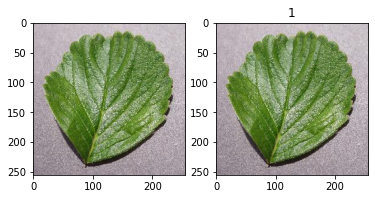

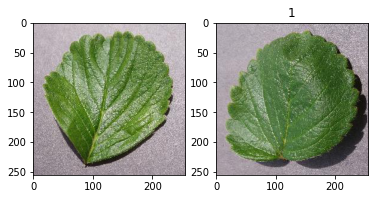

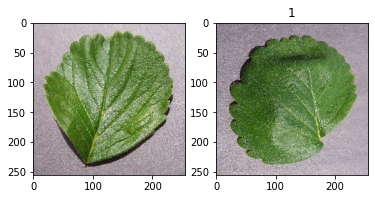

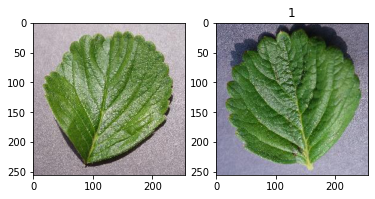

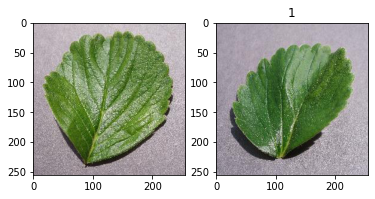

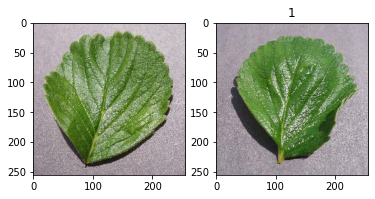

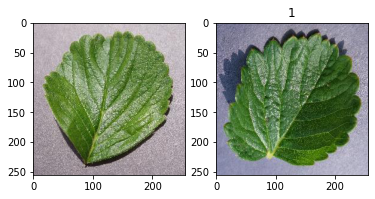

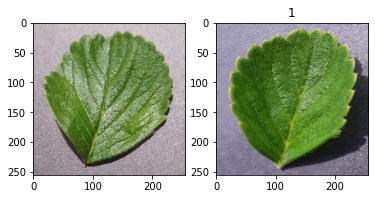

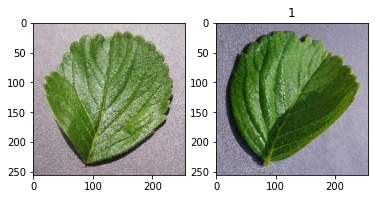

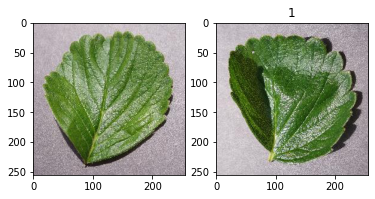

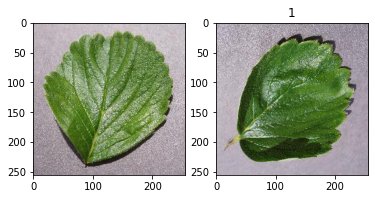

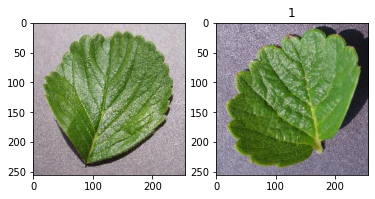

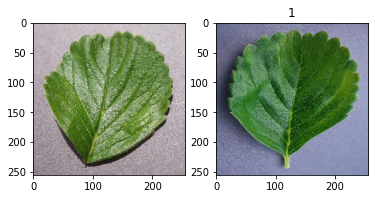

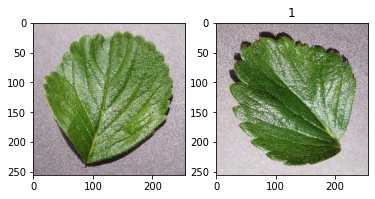

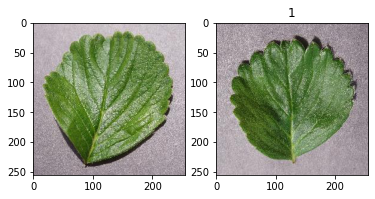

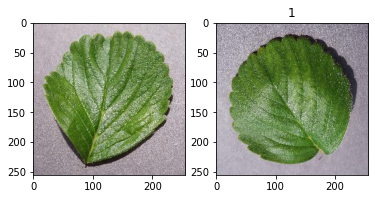

KeyboardInterrupt: 

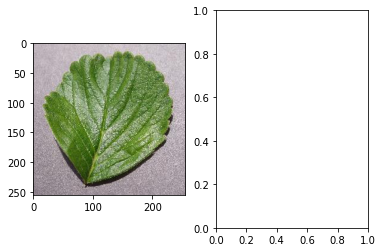

In [191]:
test_dx = 10000
for test_dx in range(2000,len(df)):
    if df[test_dx]['label'] == 1:
        fig, axs = plt.subplots(1,2)
        axs[0].imshow((df[test_dx]['healthy image'].numpy() +1)/2)
        axs[1].imshow((df[test_dx]['unknown image'].numpy() +1)/2)
        axs[1].set_title(df[test_dx]['label'])
        plt.show()